Using Google Colab's Jupyter Notebook. 
Mounting Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


For LSTM, using Keras Neural Network library.

In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")


Loading the dataset. 

In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Capstone/order_data_v3.csv')

In [0]:
df.columns = ['Date', 'sum_volume']
df.head()

,Date,sum_volume
0,1/1/2012,72747.4000
1,2/1/2012,163696.2700
2,3/1/2012,73296.6600
3,4/1/2012,86693.2200
4,5/1/2012,179203.8400


Making the column 'Date' as a Date object and setting it as Index

In [0]:
df.Date = pd.to_datetime(df.Date)
df = df.set_index('Date')

Splitting the dataset into Train and Test. 

Train - from 2012 to 2017

Test - from 2018 onwards

In [0]:
#train, test = df[:-12], df[-12:]

train, test = df.loc[:'2017'], df.loc['2018']

In [0]:
print(train.tail()); print(train.shape); print(test.head()); print(test.shape)

            sum_volume
Date                  
2017-08-01 151164.7400
2017-09-01 200465.2600
2017-10-01 195658.2600
2017-11-01 116369.1800
2017-12-01 194744.9700
(72, 1)
            sum_volume
Date                  
2018-01-01 112342.0000
2018-02-01 203537.9300
2018-03-01 111696.4900
2018-04-01 119174.2700
2018-05-01 254844.4800
(12, 1)


For LSTM, we need to Scale the data. Using MinMaxScaler
and then transform


In [0]:
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

Using TimeseriesGenerator utility class for generating batches of temporal data.




In [0]:
n_input = 12 # for 12 months
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=10)

Defining the LSTM with 500 neurons in the first hidden layer and 1 neuron in the output layer for predicting sum_volume. 

Dropout 40%.

Used the "MSE" loss function and the efficient "Adam" version of stochastic gradient descent.
The model will be fit for 180 training epochs with a batch size of 10.

In [0]:
model = Sequential()
model.add(LSTM(500, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.4))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator, epochs = 180)

In [0]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 500)               1004000   
_________________________________________________________________
dropout_7 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 501       
Total params: 1,004,501
Trainable params: 1,004,501
Non-trainable params: 0
_________________________________________________________________


Model is ready. Predicting on training data. 

In [0]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):
  pred_list.append(model.predict(batch)[0])
  batch = np.append(batch[:,1:,:],[[pred_list[i]]], axis=1)

Taking a copy of the initial test and train for later plots

In [0]:
df_train = df.loc[:'2017']; df_test = df.loc['2018']

Applying Inverse transform to get unscaled data for comparison

In [0]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list), index = df_train[-n_input:].index, columns=['Prediction'])

df_trained = pd.concat([df_train, df_predict], axis=1)

In [0]:
df_trained_mape = df_trained.tail(12)


In [0]:
df_trained_mape['MAPE'] = ((abs(df_trained_mape['sum_volume'] - df_trained_mape['Prediction']) / df_trained_mape['sum_volume'])*100).round()

In [0]:
print("MAPE of Train data : ",df_trained_mape['MAPE'].mean())

MAPE of Train data :  4.0


Plotting of last 12 month Prediction on Train data

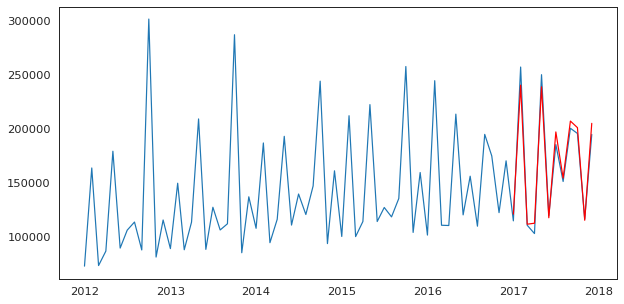

In [0]:
plt.figure(figsize=(10,5))
plt.plot(df_trained.index, df_trained['sum_volume'])
plt.plot(df_trained.index, df_trained['Prediction'], color = 'r')
plt.show()

Predicting on Test data of 2018

In [0]:
pred_list_test = []

batch = test[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):
  pred_list_test.append(model.predict(batch)[0])
  batch = np.append(batch[:,1:,:],[[pred_list_test[i]]], axis=1)

In [0]:
df_predict_test = pd.DataFrame(scaler.inverse_transform(pred_list_test), index = df_test[-n_input:].index, columns=['Prediction'])

df_trained_tested = pd.concat([df_test, df_predict_test], axis=1)

In [0]:
df_trained_tested

,sum_volume,Prediction
Date,,
2018-01-01,112342.0000,113099.1385
2018-02-01,203537.9300,213337.1931
2018-03-01,111696.4900,113397.9286
2018-04-01,119174.2700,127282.8003
2018-05-01,254844.4800,240102.3520
2018-06-01,119358.2400,117484.0377
2018-07-01,182610.8500,194170.8609
2018-08-01,136580.1900,135265.9844
2018-09-01,229870.0000,225052.2861


In [0]:
df_trained_tested['MAPE'] = ((abs(df_trained_tested['sum_volume'] - df_trained_tested['Prediction']) / df_trained_tested['sum_volume'])*100).round(4)

In [0]:
print("MAPE on Test data : ",df_trained_tested['MAPE'].mean())

MAPE on Test data :  2.9310666666666667


Plot of Prediction on Test data


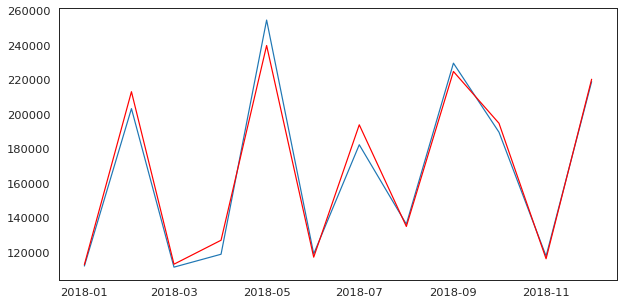

In [0]:
plt.figure(figsize=(10,5))
plt.plot(df_trained_tested.index, df_trained_tested['sum_volume'])
plt.plot(df_trained_tested.index, df_trained_tested['Prediction'], color = 'r')
plt.show()